In [ ]:
!pip install -U bitsandbytes transformers accelerate dotenv captum

In [ ]:
import os
import sys

path = os.getcwd()
sys.path.append("/kaggle/input/qnli-complete")
sys.path.append("/kaggle/input/checkpoint-qnli")

while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found.")
        break
    path = new_path

import utils
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global Parameters of Notebook
global_params = {'dataset_type': 'qnli',
                'quantization': '4bit',
                'training_mode': 'zero shot',
                'model_id': 'meta-llama/Llama-3.1-8B-Instruct'}

# Create checkpoint
checkpoint_path = utils.create_checkpoint_path(params=global_params)

Saving to: c:\Users\User\iCloudDrive\Desktop\DAMA_EAP\NLI_Study\Notebooks\QNLI_Notebooks\QNLI_Llama_3.1_8B_Instruct\Zero-Shot\checkpoint_qnli_Llama_3.1_8B_Instruct_4bit_zero_shot.pt


In [3]:
utils.hf_login("HF_TOKEN")

In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(global_params['model_id'])
model = AutoModelForCausalLM.from_pretrained(
    global_params['model_id'],
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

# Add padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

# Change the model to evaluation mode
model.eval()

In [10]:
qnli_test = pd.read_csv('/kaggle/input/qnli-complete/qnli_val.csv')

qnli_test["label"] = qnli_test["label"].map({0: "entailment", 1: "not entailment"})

In [11]:
qnli_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  5463 non-null   object
 1   sentence  5463 non-null   object
 2   label     5463 non-null   object
 3   idx       5463 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 170.8+ KB


In [12]:
qnli_test.head()

,question,sentence,label,idx
0,What came into force after the new constitutio...,"As of that day, the new constitution heralding...",entailment,0
1,What is the first major city in the stream of ...,The most important tributaries in this area ar...,not entailment,1
2,What is the minimum required if you want to te...,In most provinces a second Bachelor's Degree s...,not entailment,2
3,How was Temüjin kept imprisoned by the Tayichi...,The Tayichi'ud enslaved Temüjin (reportedly wi...,entailment,3
4,"What did Herr Gott, dich loben wir become know...","He paraphrased the Te Deum as ""Herr Gott, dich...",not entailment,4


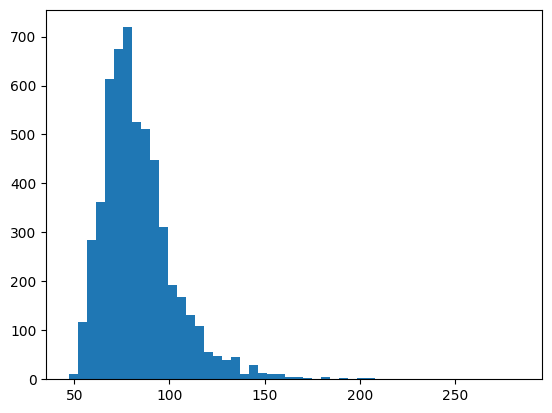

Max prompt length: 284
Max label length: 4


In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(qnli_test, tokenizer=tokenizer, dataset_type=global_params['dataset_type'])

In [ ]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=qnli_test,
                               tokenizer=tokenizer,
                               dataset_type=global_params['dataset_type'],
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 16 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Test
predictions, gold_labels, batch_probs = utils.test_run(model=model,
                                          dataloader=dataloader,
                                          tokenizer=tokenizer,
                                          dataset_type=global_params['dataset_type'])

for i, pair in enumerate(zip(predictions, gold_labels)):
    print(pair, batch_probs[i])

('not entailment', 'entailment') tensor([0.3032, 0.6968])
('not entailment', 'not entailment') tensor([0.4330, 0.5670])
('entailment', 'not entailment') tensor([0.8944, 0.1056])
('not entailment', 'entailment') tensor([0.2334, 0.7666])
('not entailment', 'not entailment') tensor([0.0494, 0.9506])
('not entailment', 'not entailment') tensor([0.1510, 0.8490])
('not entailment', 'not entailment') tensor([0.4571, 0.5429])
('not entailment', 'not entailment') tensor([0.0128, 0.9872])
('entailment', 'not entailment') tensor([0.6671, 0.3329])
('not entailment', 'entailment') tensor([0.0924, 0.9076])
('not entailment', 'not entailment') tensor([0.2309, 0.7691])
('not entailment', 'entailment') tensor([0.0947, 0.9053])
('not entailment', 'entailment') tensor([0.0480, 0.9520])
('not entailment', 'not entailment') tensor([0.2444, 0.7556])
('not entailment', 'not entailment') tensor([0.3486, 0.6514])
('not entailment', 'entailment') tensor([0.0044, 0.9956])


In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)
labels = utils.get_labels(global_params['dataset_type'])

# Loop over the batches
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):

        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        batch_probs = utils.get_model_probs(batch_input_ids=input_ids_batch,
                                      batch_attention_mask=attention_mask_batch,
                                      dataset_type=global_params['dataset_type'],
                                      model=model,
                                      tokenizer=tokenizer)

        if torch.isnan(batch_probs).any():
            print("Warning: NaNs detected in batch_probs")
            
        batch_pred_indices = torch.argmax(batch_probs, dim=1)
        batch_pred_labels = [labels[i] for i in batch_pred_indices]

        predicted_labels.extend(batch_pred_labels)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

No checkpoint found.


Evaluating:   0%|          | 1/342 [00:21<2:02:50, 21.61s/batch]

Checkpoint saved: 1, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating:  15%|█▍        | 51/342 [19:55<1:54:02, 23.51s/batch]

Checkpoint saved: 51, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating:  30%|██▉       | 101/342 [39:30<1:34:19, 23.48s/batch]

Checkpoint saved: 101, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating:  44%|████▍     | 151/342 [59:05<1:14:42, 23.47s/batch]

Checkpoint saved: 151, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating:  59%|█████▉    | 201/342 [1:18:40<55:10, 23.48s/batch]  

Checkpoint saved: 201, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating:  73%|███████▎  | 251/342 [1:38:15<35:40, 23.53s/batch]

Checkpoint saved: 251, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating:  88%|████████▊ | 301/342 [1:57:50<16:03, 23.49s/batch]

Checkpoint saved: 301, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Evaluating: 100%|██████████| 342/342 [2:13:40<00:00, 23.45s/batch]

Checkpoint saved: 342, /kaggle/working/checkpoint_qnli_Llama_3.1_8B_Instruct_4bit.pt


Checkpoint found.
Accuracy: 0.5356.
 F1 Score: 0.4435.
 Matthew's Correlation Coefficient: 0.1049.
 Cohen's Kappa Score: 0.0631.


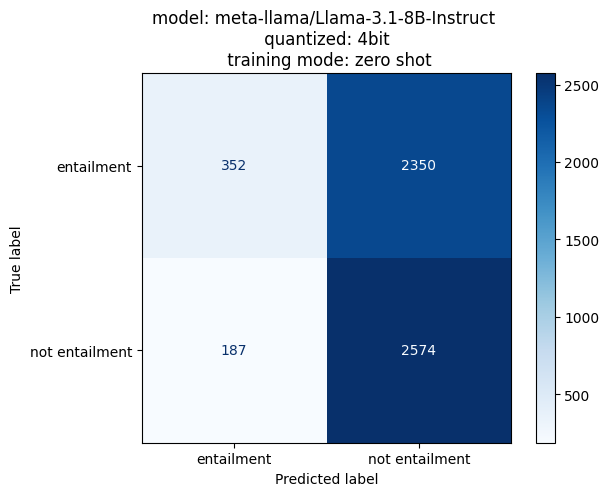

In [3]:
# Calculate metrics
predicted_labels, gold_labels, batch = utils.load_checkpoint(checkpoint_path)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, params=global_params)